In [106]:
from SPARQLWrapper import SPARQLWrapper, JSON
import os
import pandas as pd

%matplotlib inline

In [2]:
sparql = SPARQLWrapper("http://localhost:9999/blazegraph/namespace/hogeraad/sparql")

In [47]:
def sparql_result_to_df(result):
    cols = result['head']['vars']
    rows_dicts = result['results']['bindings']
    rows = [{c: r.get(c, {'value': None})['value'] for c in cols} for r in rows_dicts]
    return pd.DataFrame(rows)[cols]

In [79]:
queryString = """
    prefix dcterm: <http://purl.org/dc/terms/> 
    select ?type (count(?s) as ?count)
    {
        ?s dcterm:type ?type.
    }
    group by ?type
"""

sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)
ret = sparql.query()
result = ret.convert()
sparql_result_to_df(result)

,type,count
0,Jurisprudentie,58
1,Wet,24
2,Verdrag,1
3,Amvb,1


In [40]:
# wich attributes can appear multiple times?
queryString = """
    prefix dcterm: <http://purl.org/dc/terms/> 
    select ?p (count(?o) as ?count) 
    {
        ?s dcterm:type "Jurisprudentie".
        ?s ?p ?o.
    }
    group by ?s ?p
    having(count(?o)>1)
    order by ?p
"""

sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)
ret = sparql.query()
result = ret.convert()
sparql_result_to_df(result)

,p,count
0,http://purl.org/dc/terms/identifier,2
1,http://purl.org/dc/terms/identifier,2
2,http://purl.org/dc/terms/identifier,2
3,http://purl.org/dc/terms/identifier,2
4,http://purl.org/dc/terms/identifier,2
5,http://purl.org/dc/terms/identifier,2
6,http://purl.org/dc/terms/identifier,2
7,http://purl.org/dc/terms/identifier,2


In [42]:
# wich attributes does a case have?
queryString = """
    prefix dcterm: <http://purl.org/dc/terms/> 
    select ?p (count(?o) as ?count) 
    {
        ?s dcterm:type "Jurisprudentie".
        ?s ?p ?o.
    }
    group by ?p
"""

sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)
ret = sparql.query()
result = ret.convert()
sparql_result_to_df(result)

,p,count
0,http://linkeddata.overheid.nl/terms/kleur,8
1,http://linkeddata.overheid.nl/terms/volgorde,8
2,http://purl.org/dc/terms/creator,2
3,http://purl.org/dc/terms/identifier,16
4,http://purl.org/dc/terms/type,8
5,http://purl.org/dc/terms/hasVersion,8
6,http://purl.org/dc/terms/modified,8
7,http://purl.org/dc/terms/title,8


In [204]:
# Nodes: all jurispidentie
queryString = """
    prefix dcterm: <http://purl.org/dc/terms/> 
    select ?id ?creator ?title
    {
        ?id dcterm:type "Jurisprudentie".
        optional { ?id dcterm:creator ?creator. }
        optional { ?id dcterm:title ?title }
    }
"""

sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)
ret = sparql.query()
result = ret.convert()
cases = sparql_result_to_df(result)
ecli_regex = '(ECLI:[A-Z]{2}:[A-Z]*:[0-9]{4}:[0-9A-Z\.]{1,25}$)'
cases['ecli'] = cases.id.str.extract(ecli_regex, expand=False)
cases.shape

(82, 4)

In [205]:
# Links between cases
queryString = """
    prefix dcterm: <http://purl.org/dc/terms/> 
    prefix overheidrl: <http://linkeddata.overheid.nl/terms/>
    select ?link_id ?source ?target ?link_type ?link_type_label
    {
        ?source dcterm:type "Jurisprudentie".
        ?target dcterm:type "Jurisprudentie".
        ?link_id overheidrl:heeftLinktype ?link_type.
        ?link_id overheidrl:linktVan  ?source.
        ?link_id overheidrl:linktNaar  ?target.
        ?link_type rdfs:label ?link_type_label
    }
"""

sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)
ret = sparql.query()
result = ret.convert()
links = sparql_result_to_df(result)
links.shape

(30, 5)

In [206]:
# Legislation references
# Links between cases
queryString = """
    prefix dcterm: <http://purl.org/dc/terms/> 
    prefix overheidrl: <http://linkeddata.overheid.nl/terms/>
    select ?link_id ?source ?target ?link_type ?link_type_label
    {
        ?source dcterm:type "Jurisprudentie".
        ?target dcterm:type "Wet".
        ?link_id overheidrl:heeftLinktype ?link_type.
        ?link_id overheidrl:linktVan  ?source.
        ?link_id overheidrl:linktNaar  ?target.
        ?link_type rdfs:label ?link_type_label
    }
"""

sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)
ret = sparql.query()
result = ret.convert()
legislation = sparql_result_to_df(result)
legislation.shape

(13, 5)

## Enrich the nodes

In [207]:
import caselawnet

In [208]:
nodes_enriched = caselawnet.enrich_eclis(list(cases['ecli']))

Retrieved ECLI:NL:HR:2005:AT2829 from web
Retrieved ECLI:NL:PHR:2005:AT2829 from web
Retrieved ECLI:NL:PHR:2006:AU8317 from web
Retrieved ECLI:NL:PHR:2010:BL6182 from web
Retrieved ECLI:NL:PHR:2010:BM0710 from web
Retrieved ECLI:NL:PHR:2011:BP4943 from web
Retrieved ECLI:NL:HR:2017:2969 from web
Retrieved ECLI:NL:PHR:2017:1276 from web
Retrieved ECLI:NL:GHAMS:2014:1135 from web
Retrieved ECLI:NL:GHAMS:2016:4635 from web
Retrieved ECLI:NL:GHAMS:2017:3101 from web
Retrieved ECLI:NL:GHARL:2014:174 from web
Retrieved ECLI:NL:GHARL:2014:8612 from web
Retrieved ECLI:NL:GHARL:2014:9846 from web
Retrieved ECLI:NL:GHARL:2016:5454 from web
Retrieved ECLI:NL:GHARL:2017:6577 from web
Retrieved ECLI:NL:GHDHA:2015:32 from web
Retrieved ECLI:NL:GHSHE:2010:BU3862 from web
Retrieved ECLI:NL:GHSHE:2014:1736 from web
Retrieved ECLI:NL:GHSHE:2014:1775 from web
Retrieved ECLI:NL:GHSHE:2014:2077 from web
Retrieved ECLI:NL:GHSHE:2014:2763 from web
Retrieved ECLI:NL:HR:2013:CA1725 from web
Retrieved ECLI:NL:G

In [209]:
nodes_enriched_df = pd.DataFrame(nodes_enriched)
cases_merged = cases.merge(nodes_enriched_df[['ecli', 'subject', 'creator', 'year', 'date', 'abstract']], on='ecli')

In [210]:
cases_merged['creator'] = [c['creator_x'] if c['creator_x'] else c['creator_y'].split('/')[-1].replace('_', ' ')
                           for i, c in cases_merged.iterrows()]

In [211]:
cases_merged

,id,creator_x,title,ecli,subject,creator_y,year,date,abstract,creator
0,http://linkeddata.overheid.nl/terms/jurisprude...,Hoge Raad der Nederlanden,"ECLI:NL:HR:2005:AT2829 - Hoge Raad, 13-05-2005...",ECLI:NL:HR:2005:AT2829,http://psi.rechtspraak.nl/rechtsgebied#civielR...,http://standaarden.overheid.nl/owms/terms/Hoge...,2005,2005-05-13,13 mei 2005 Eerste Kamer Rek.nr. R03/149HR (OK...,Hoge Raad der Nederlanden
1,http://linkeddata.overheid.nl/terms/jurisprude...,None,ECLI:NL:PHR:2005:AT2829 - Parket bij de Hoge R...,ECLI:NL:PHR:2005:AT2829,http://psi.rechtspraak.nl/rechtsgebied#civielR...,http://standaarden.overheid.nl/owms/terms/Park...,2005,2005-05-13,13 mei 2005 Eerste Kamer Rek.nr. R03/149HR (OK...,Parket bij de Hoge Raad
2,http://linkeddata.overheid.nl/terms/jurisprude...,None,ECLI:NL:PHR:2006:AU8317 - Parket bij de Hoge R...,ECLI:NL:PHR:2006:AU8317,http://psi.rechtspraak.nl/rechtsgebied#civielR...,http://standaarden.overheid.nl/owms/terms/Park...,2006,2006-03-17,Geschil tussen een gemeente en marktkooplieden...,Parket bij de Hoge Raad
3,http://linkeddata.overheid.nl/terms/jurisprude...,None,ECLI:NL:PHR:2010:BL6182 - Parket bij de Hoge R...,ECLI:NL:PHR:2010:BL6182,http://psi.rechtspraak.nl/rechtsgebied#civielR...,http://standaarden.overheid.nl/owms/terms/Park...,2010,2010-04-16,Ondernemingsrecht. Enquête. Voorlopige voorzie...,Parket bij de Hoge Raad
4,http://linkeddata.overheid.nl/terms/jurisprude...,None,ECLI:NL:PHR:2010:BM0710 - Parket bij de Hoge R...,ECLI:NL:PHR:2010:BM0710,http://psi.rechtspraak.nl/rechtsgebied#civielR...,http://standaarden.overheid.nl/owms/terms/Park...,2010,2010-06-25,Enquêterecht. Wanbeleid. Tijdelijke overdracht...,Parket bij de Hoge Raad
5,http://linkeddata.overheid.nl/terms/jurisprude...,None,ECLI:NL:PHR:2011:BP4943 - Parket bij de Hoge R...,ECLI:NL:PHR:2011:BP4943,http://psi.rechtspraak.nl/rechtsgebied#civielR...,http://standaarden.overheid.nl/owms/terms/Park...,2011,2011-04-08,Enquête. Bevoegdheid tot indienen verzoek; art...,Parket bij de Hoge Raad
6,http://linkeddata.overheid.nl/terms/jurisprude...,Hoge Raad der Nederlanden,"ECLI:NL:HR:2017:2969 - Hoge Raad, 21-11-2017 /...",ECLI:NL:HR:2017:2969,http://psi.rechtspraak.nl/rechtsgebied#strafrecht,http://standaarden.overheid.nl/owms/terms/Hoge...,2017,2017-11-21,Feitelijke leiding geven aan het opzettelijk o...,Hoge Raad der Nederlanden
7,http://linkeddata.overheid.nl/terms/jurisprude...,None,ECLI:NL:PHR:2017:1276 - Parket bij de Hoge Raa...,ECLI:NL:PHR:2017:1276,http://psi.rechtspraak.nl/rechtsgebied#strafrecht,http://standaarden.overheid.nl/owms/terms/Park...,2017,2017-10-03,Feitelijke leiding geven aan het opzettelijk o...,Parket bij de Hoge Raad
8,http://linkeddata.overheid.nl/terms/jurisprude...,None,ECLI:NL:GHAMS:2014:1135 - Gerechtshof Amsterda...,ECLI:NL:GHAMS:2014:1135,http://psi.rechtspraak.nl/rechtsgebied#civielR...,http://standaarden.overheid.nl/owms/terms/Gere...,2014,2014-04-01,Effectenlease. Het hof komt niet terug op eerd...,Gerechtshof Amsterdam
9,http://linkeddata.overheid.nl/terms/jurisprude...,None,ECLI:NL:GHAMS:2016:4635 - Gerechtshof Amsterda...,ECLI:NL:GHAMS:2016:4635,http://psi.rechtspraak.nl/rechtsgebied#civielR...,http://standaarden.overheid.nl/owms/terms/Gere...,2016,2016-11-15,schending bijzondere zorgplicht beleggingsadvi...,Gerechtshof Amsterdam


## Network stuff

In [212]:
import networkx as nx
import matplotlib.pyplot as plt

In [213]:
cases_merged['creator'].value_counts()

Hoge Raad der Nederlanden         19
Parket bij de Hoge Raad           19
Gerechtshof Arnhem-Leeuwarden     15
Gerechtshof 's-Hertogenbosch      10
Gerechtshof Amsterdam              6
Gerechtshof Den Haag               5
                                   3
Gerechtshof Arnhem                 2
Rechtbank s-Gravenhage             1
Rechtbank Noord-Holland            1
Rechtbank Zeeland-West-Brabant     1
Name: creator, dtype: int64

In [214]:
creator.find('ger')

-1

In [215]:
def colormap(creator):
    if creator == 'Hoge Raad der Nederlanden':
        return 'red'
    if creator == 'Parket bij de Hoge Raad':
        return 'blue'
    if creator.find("Gerechtshof")>=0:
        return 'green'
    else:
        return 'yellow'

In [216]:
network = nx.DiGraph()

In [217]:
for i, case in cases_merged.iterrows():
    id0 = case['id']
    creator = case.get('creator', '')
    network.add_node(id0, {'creator': creator, 'color': colormap(creator)})

In [218]:
for i, link in links.iterrows():
    source = link['source']
    target = link['target']
    link_type = link['link_type_label']
    network.add_edge(source, target, {'link_type': link_type})

In [219]:
network_degree = network.degree()
connected_nodes = [n for n in  network_degree if network_degree[n] > 0]

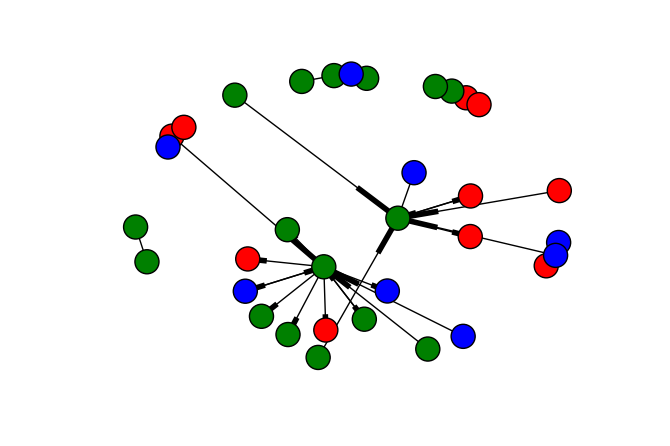

In [220]:
nx.draw(network, 
        pos=nx.spring_layout(network),
        nodelist = connected_nodes,
        node_color=list(nx.get_node_attributes(network, 'color').values()))

In [169]:
nx.draw_networkx?